# Test low inclination recovery

#### MSP

Plan:
1. Use DiscModel to make mock galaxies
2. Incline models and image at varying pixel qualities
3. Use both in-built and standalone flex to compute the coefficients
4. Use an inclination inverter to try and recover the relationship

### Needed imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from flex import FLEX
from src.DiscModel import DiscGalaxy
# DiscModel
#os.chdir('src');import DiscModel as DiscModel;os.chdir('..')

# FLEX base pipeline install


### Inclination inverter definition

In [2]:
A=-0.30845928737374684
B=-1.6564105427131928
C=6.430938401182824
D=0.3145522357466893

def FindInc2(eta, A=A, B=B, C=C, D=D,etalim=1.0):
    
    if eta>etalim:
        inc=90
    else:
        # 1) Safe inverse argument (A can be negative)
        x = np.clip((eta - D) / A, -1.0, 1.0)

        # 2) Two branches from cos symmetry, all in radians
        a = np.arccos(x)                # in [0, pi]
        i1 = (a - C) / B
        i2 = (-a - C) / B

        # 3) Convert candidates to degrees
        cand = np.rad2deg(np.array([i1, i2]))

        # 4) Reduce by the period in degrees: P = 2π/|B| (then to degrees)
        P = np.rad2deg(2*np.pi / abs(B))
        cand = cand % P                 # map into one period

        # 5) Fold into [0, 180], then reflect >90 across 90 to get [0, 90]
        cand = np.where(cand > 180.0, cand - 180.0, cand)
        cand = np.where(cand > 90.0, 180.0 - cand, cand)

        # 6) Pick the candidate that best reproduces eta (keeps you on the line)
        def model(i_deg):
            return A*np.cos(B*np.deg2rad(i_deg) + C) + D

        errs = np.abs(model(cand) - eta)
        inc=float(cand[np.argmin(errs)])
    return inc


### Compare DiscModel to raw flex

Text(0, 0.5, 'Recovered - True Inclination (deg)')

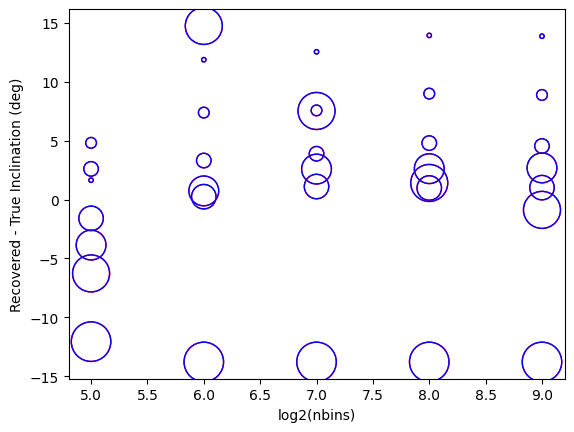

In [3]:
rmax = 20.
mmax=2
nmax=10

# test a few inclinations
for inc in [0,5,10,30,45,70,80]:
    inclinationvalue = inc

    # test a few resolutions
    for n in [5,6,7,8,9]:
        nbins = 2**n
        a = 1.0

        D = DiscGalaxy(N=100000, a=a)  # start with small N for speed
        D.rotate_disc(inclinationvalue, 0, 0)
        D.generate_image(rmax=rmax, nbins=nbins, noiselevel=0.0)

        # make the expansion using DiscModel in-built function
        L = D.make_expansion(mmax,nmax,a,noisy=False)
        num = np.linalg.norm(np.sqrt(L.coscoefs[2]**2 + L.sincoefs[2]**2))
        den = np.linalg.norm(L.coscoefs[0])
        #print('built in',inclinationvalue,n,np.round(num/den,4),FindInc2(num/den))

        plt.scatter(n,FindInc2(num/den)-inclinationvalue,facecolors='none',edgecolors='red',s=inclinationvalue*10+10)

        # make the expansion using standalone FLEX
        X,Y = np.meshgrid(D.x_centers,D.y_centers,indexing='ij')
        R,P = np.sqrt(X**2 + Y**2), np.arctan2(Y,X)  # polar coordinates
        L = FLEX(a,mmax,nmax, R.flatten(), P.flatten(), mass=D.img.flatten())
        num = np.linalg.norm(np.sqrt(L.coscoefs[2]**2 + L.sincoefs[2]**2))
        den = np.linalg.norm(L.coscoefs[0])
        #print('FLEX',inclinationvalue,n,np.round(num/den,4),FindInc2(num/den))

        plt.scatter(n,FindInc2(num/den)-inclinationvalue,facecolors='none',edgecolors='blue',s=inclinationvalue*10+10)

plt.xlabel('log2(nbins)')
plt.ylabel('Recovered - True Inclination (deg)')


In this figure, the smallest sizes correspond to the most face on, and the largest sizes to the most edge on. The recovery is the same between DiscModel and flex, as far as I can tell. There is a systematic departure to overestimating the inclinations at small inclinations, even with increased resolution.